##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Regresion Basica: Predecir eficiencia de gasolina

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/es-419/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Note: Nuestra comunidad de Tensorflow ha traducido estos documentos. Como las traducciones de la comunidad
son basados en el "mejor esfuerzo", no hay ninguna garantia que esta sea un reflejo preciso y actual 
de la [Documentacion Oficial en Ingles](https://www.tensorflow.org/?hl=en).
Si tienen sugerencias sobre como mejorar esta traduccion, por favor envian un "Pull request"
al siguiente repositorio [tensorflow/docs](https://github.com/tensorflow/docs).
Para ofrecerse como voluntario o hacer revision de las traducciones de la Comunidad
por favor contacten al siguiente grupo [docs@tensorflow.org list](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs).

En un problema de *regresion*, buscamos predecir la salida de un valor continuo como la probabilidad de un precio. En contraste en un problema de *Clasificacion*, buscamos seleccionar una clase de una lista de clases (por ejemplo, en donde una imagen contenga una manzana o una naranja queremos reconocer cual es la fruta en la imagen).

Este libro usa el set de datos clasico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construye un modelo para predecir la eficiencia de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.

Este ejemplo usa el API `tf.keras` , revise [Esta Guia](https://www.tensorflow.org/guide/keras) para obtener mas detalles.

In [3]:
# Use seaborn for pairplot
!pip install -q seaborn

You should consider upgrading via the 'z:\data_science\software\python\python_3.6.4\python.exe -m pip install --upgrade pip' command.


In [4]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.1


## El set de Datos de MPG

el set de datos esta disponible de el siguiente repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Obtenga la data
Primero descargue el set de datos.

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 5us/step


'C:\\Users\\gvazquez\\.keras\\datasets\\auto-mpg.data'

Importelo usando pandas.

In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Limpie la data

El set de datos contiene algunos valores desconocidos.

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

**Para** Mantener este tutorial inicial sencillo eliminemos las siguientes filas.

In [8]:
dataset = dataset.dropna()

La columna de `"Origin"` realmente es categorica, no numerica. Entonces conviertala a un "one-hot":

In [34]:
origin = dataset.pop('Origin')


KeyError: 'Origin'

In [36]:
origin.value_counts()

1    245
3     79
2     68
Name: Origin, dtype: int64

In [10]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### Dividamos la data en entrenamiento y prueba

Ahora divida el set de datos en un set de entrenamiento y otro de pruebas.

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

In [11]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspeccione la data

Revise rapidamente la distribucion conjunta de un par de columnas de el set de entrenamiento.

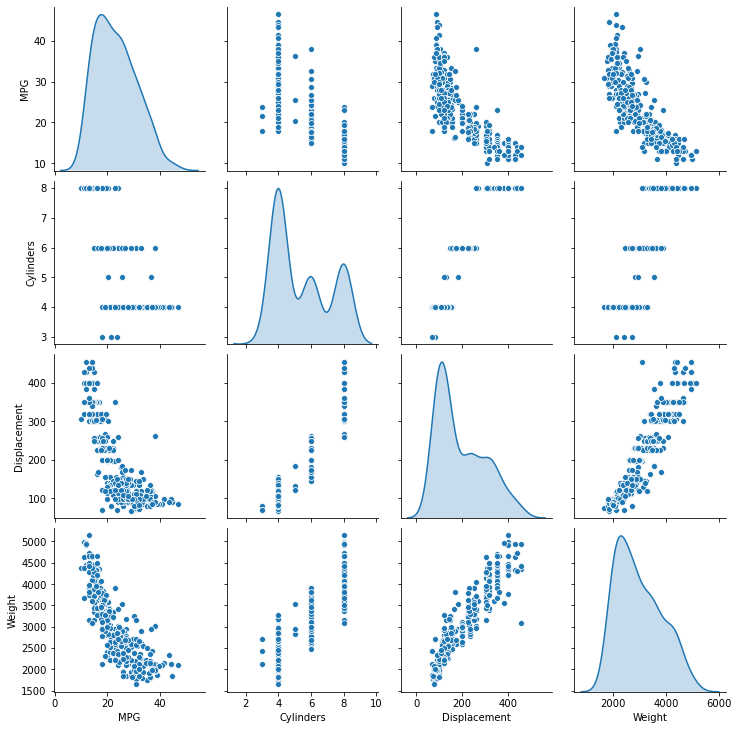

In [12]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Tambien revise las estadisticas generales:

In [13]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### Separe las caracteristicas de las etiquetas.

Separe el valor objetivo, o la "etiqueta" 
de las caracteristicas. Esta etiqueta es el valor que entrenara el modelo para predecir.

In [14]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalice la data

Revise otra vez el bloque de `train_stats` que se presento antes y note la diferencia de rangos de cada caracteristica.

Es una buena práctica normalizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo * podría * converger sin normalización de características, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

Nota: Aunque generamos intencionalmente estas estadísticas solo del conjunto de datos de entrenamiento, estas estadísticas también se utilizarán para normalizar el conjunto de datos de prueba. Necesitamos hacer eso para proyectar el conjunto de datos de prueba en la misma distribución en la que el modelo ha sido entrenado.

In [32]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [33]:
normed_train_datas = normed_train_data.describe()
normed_train_datas = normed_train_data.transpose()
normed_train_datas

,146,282,69,378,331,257,310,328,125,108,...,171,70,307,49,209,281,229,150,145,182
Cylinders,-0.869348,-0.869348,1.483887,-0.869348,-0.869348,0.307270,-0.869348,-0.869348,0.307270,-0.869348,...,-0.869348,1.483887,0.307270,-0.869348,-0.869348,0.307270,1.483887,-0.869348,-0.869348,-0.869348
Displacement,-1.009459,-0.530218,1.482595,-0.865687,-0.942365,0.351586,-1.019044,-0.472709,0.025702,-0.942365,...,-0.587727,1.961837,-0.213919,-0.702745,-0.721914,0.044872,1.961837,-0.836932,-1.076553,-0.846517
Horsepower,-0.784052,-0.442811,1.447140,-1.099044,-0.994047,-0.390312,-1.177792,-0.994047,-0.259066,-0.442811,...,-0.232816,2.234620,0.265921,-0.495310,-0.442811,-0.521559,1.972127,-0.311564,-1.151543,-0.495310
Weight,-1.025303,-0.118796,1.736877,-1.025303,-1.001603,0.260397,-1.211344,0.307796,0.132419,-0.842816,...,-0.341571,1.696588,-0.343941,-0.912730,0.331495,-0.000298,1.457223,-0.710099,-1.169870,-0.623596
Acceleration,-0.379759,0.624102,-0.738281,-0.308055,0.875068,0.588250,1.161885,2.237451,0.337285,1.233589,...,-0.738281,-1.096803,-0.953394,-0.559020,2.273303,0.946772,-1.598734,-0.021237,1.233589,-0.021237
Model Year,-0.516397,0.843910,-1.060519,1.660094,1.115971,0.571849,1.115971,1.115971,-0.516397,-0.788458,...,-0.244335,-1.060519,0.843910,-1.332580,0.027726,0.843910,0.299787,-0.516397,-0.516397,0.027726
USA,0.774676,0.774676,0.774676,0.774676,-1.286751,0.774676,-1.286751,-1.286751,0.774676,-1.286751,...,-1.286751,0.774676,0.774676,0.774676,-1.286751,0.774676,0.774676,-1.286751,-1.286751,-1.286751
Europe,-0.465148,-0.465148,-0.465148,-0.465148,-0.465148,-0.465148,-0.465148,2.143005,-0.465148,-0.465148,...,-0.465148,-0.465148,-0.465148,-0.465148,2.143005,-0.465148,-0.465148,-0.465148,-0.465148,2.143005
Japan,-0.495225,-0.495225,-0.495225,-0.495225,2.012852,-0.495225,2.012852,-0.495225,-0.495225,2.012852,...,2.012852,-0.495225,-0.495225,-0.495225,-0.495225,-0.495225,-0.495225,2.012852,2.012852,-0.495225


Estos datos normalizados es lo que usaremos para entrenar el modelo.

Precaución: las estadísticas utilizadas para normalizar las entradas aquí (media y desviación estándar) deben aplicarse a cualquier otro dato que se alimente al modelo, junto con la codificación de un punto que hicimos anteriormente. Eso incluye el conjunto de pruebas, así como los datos en vivo cuando el modelo se usa en producción.

## El modelo

### Construye el modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo. Los pasos de construcción del modelo se envuelven en una función, `build_model`, ya que crearemos un segundo modelo, más adelante.

In [16]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [17]:
model = build_model()

### Inspeccione el modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Ahora pruebe el modelo. Tome un lote de ejemplos `10` de los datos de entrenamiento y llame a` model.predict` en él.

In [19]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.29657444],
       [ 0.05814034],
       [ 0.81005603],
       [ 0.05403864],
       [-0.12132289],
       [ 0.13497467],
       [-0.13547239],
       [ 0.84961665],
       [ 0.08360185],
       [-0.2349621 ]], dtype=float32)

Parece estar funcionando, y produce un resultado de la forma y tipo esperados.

### Entrenar a la modelo

Entrene el modelo durante 1000 épocas y registre la precisión de entrenamiento y validación en el objeto `history`.

In [28]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    print('ñ', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

ññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññ

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.529720,0.954532,2.529720,10.195983,2.395233,10.195983,995
996,2.673167,1.027425,2.673167,9.629807,2.361765,9.629807,996
997,2.777601,1.038755,2.777601,9.589409,2.340997,9.589409,997
998,2.577944,0.997813,2.577944,9.621440,2.353982,9.621440,998
999,2.709280,1.023922,2.709280,9.960228,2.402302,9.960228,999


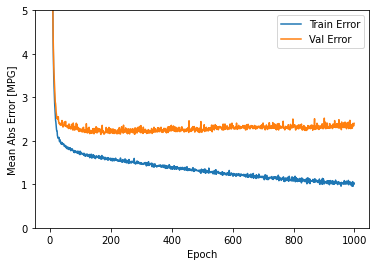

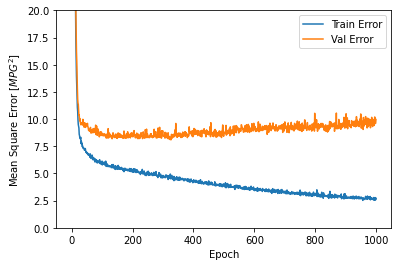

In [22]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

Este gráfico muestra poca mejora, o incluso degradación en el error de validación después de aproximadamente 100 épocas. Actualicemos la llamada `model.fit` para detener automáticamente el entrenamiento cuando el puntaje de validación no mejore. Utilizaremos una * devolución de llamada de EarlyStopping * que pruebe una condición de entrenamiento para cada época. Si transcurre una cantidad determinada de épocas sin mostrar mejoría, entonces detiene automáticamente el entrenamiento.

Puedes obtener más información sobre esta devolución de llamada [Aca](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).

ñññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññ

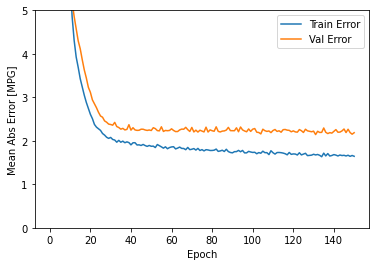

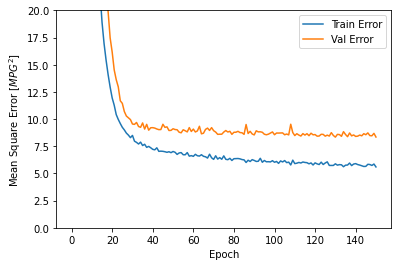

In [29]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

El gráfico muestra que en el conjunto de validación, el error promedio generalmente es de alrededor de +/- 2 MPG. ¿Es esto bueno? Le dejaremos esa decisión a usted.

Veamos qué tan bien generaliza el modelo al usar el conjunto ** test **, que no usamos al entrenar el modelo. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real.

In [30]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.6592 - mae: 1.8499 - mse: 5.6592
Testing set Mean Abs Error:  1.85 MPG


### Haga Predicciones

Finalmente, prediga los valores de MPG utilizando datos en el conjunto de pruebas:

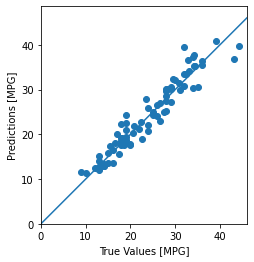

In [31]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

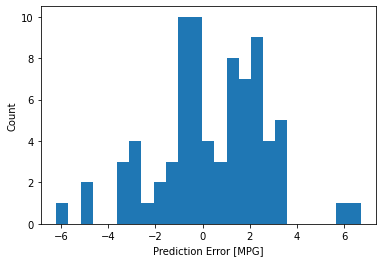

In [26]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

## Conclusion

Este cuaderno introdujo algunas técnicas para manejar un problema de regresión.

* El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
* Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
* Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
* Si no hay muchos datos de entrenamiento, una técnica es preferir una red pequeña con pocas capas ocultas para evitar el sobreajuste.
* La detención temprana es una técnica útil para evitar el sobreajuste.